In [1]:
import re
import sys
import yaml
import torch
import librosa
import museval
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../")
from kaituoxu.conv_tasnet import ConvTasNet
from asteroid.data import MUSDB18Dataset

In [2]:
DATA_DIR = Path("../../../data/musdb18")

TEST_SONG = Path("../musdb_data/test/Al James - Schoolboy Facination.stem.mp4")

assert DATA_DIR.is_dir()

TRAINING_DIR = Path("../experiment_results/exp-7/training_20220309-225520")

assert TRAINING_DIR.is_dir()

cfg_path = next(TRAINING_DIR.glob('*.yaml'))
history_path = TRAINING_DIR/"history.csv"

best_model_path = TRAINING_DIR/'model.pth'
model_paths = sorted(list(TRAINING_DIR.glob("model_*")), key=lambda x: int("".join(re.findall(r"\d", str(x)))))

with open(str(cfg_path), 'r') as file:
    CFG = yaml.load(file, Loader=yaml.FullLoader)

assert cfg_path.exists() and history_path.exists() and cfg_path.exists()

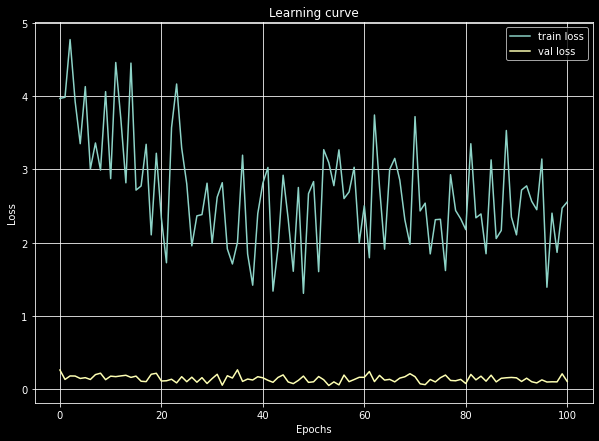

In [3]:
df = pd.read_csv(history_path)
epochs = df.index.values
train_loss = df.train_loss
val_loss = df.val_loss

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.plot();
plt.savefig(str(TRAINING_DIR/"LR.jpg"))

In [4]:
SEGMENT_SIZE = CFG["segment_size"]
RANDOM_TRACK_MIX = CFG["random_track_mix"]
TARGETS = CFG["targets"]
N_SRC = len(TARGETS)
LOSS = CFG["loss"]
STORE_GRADIENT_NORM = CFG["store_gradient_norm"]
VERBOSE = CFG["verbose"]
SAVE_WEIGHTS_EACH_EPOCH = CFG["save_weights_each_epoch"]

#####################
##### HYPER-PARAMETERS
#####################
SAMPLE_RATE = CFG["sample_rate"]
SIZE = None if CFG["size"] == -1 else CFG["size"]
LR = CFG["learning_rate"]
N_EPOCHS = CFG["n_epochs"]
TRAIN_BATCH_SIZE = CFG["train_batch_size"]
TEST_BATCH_SIZE = CFG["test_batch_size"]
NUM_WORKERS = CFG["num_workers"]
if "device" in CFG:
    if CFG["device"] == "cuda" and torch.cuda.is_available():
        DEVICE = torch.device("cuda")
    else:
        DEVICE = torch.device("cpu")
else:
    DEVICE = "cpu"

X = CFG["X"]
R = CFG["R"]
B = CFG["B"]
H = CFG["H"]
Sc = CFG["Sc"]
P = CFG["P"]
L = CFG["L"]
N = CFG["N"]
STRIDE = CFG["stride"]
CLIP = CFG["gradient_clipping"]

model = ConvTasNet(
    C=N_SRC,
    X=X,
    R=R,
    B=B,
    H=H,
    P=P,
    L=L,
    N=N,
    stride=STRIDE,
    mask_nonlinear="softmax",
    device=DEVICE
).to(DEVICE)

model.load_state_dict(torch.load(best_model_path)["model_state_dict"])

<All keys matched successfully>

In [5]:
test_dataset = MUSDB18Dataset(
    root=DATA_DIR.__str__(),
    targets=TARGETS,
    suffix=".mp4",
    split="test",
    subset=None,
    segment=1,
    samples_per_track=1,
    random_segments=True,
    random_track_mix=RANDOM_TRACK_MIX,
    sample_rate=SAMPLE_RATE,
    size=SIZE
)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0)

50it [00:01, 39.42it/s]


In [6]:
"""
for i, (x, y) in enumerate(test_loader):
    wavfile.write(f"./{i}-mix.wav", SAMPLE_RATE, x[0].detach().numpy())
    for j, name in enumerate(TARGETS):
        wavfile.write(f"./{i}-{name}.wav", SAMPLE_RATE, y[0][j].detach().numpy())
"""

'\nfor i, (x, y) in enumerate(test_loader):\n    wavfile.write(f"./{i}-mix.wav", SAMPLE_RATE, x[0].detach().numpy())\n    for j, name in enumerate(TARGETS):\n        wavfile.write(f"./{i}-{name}.wav", SAMPLE_RATE, y[0][j].detach().numpy())\n'

In [7]:
import warnings
warnings.filterwarnings('ignore')

COLUMNS = ["vocals", "other", "bass", "drums"]
df_sdr = pd.DataFrame(data=[], columns=COLUMNS)
df_isr = pd.DataFrame(data=[], columns=COLUMNS)
df_sir = pd.DataFrame(data=[], columns=COLUMNS)
df_sar = pd.DataFrame(data=[], columns=COLUMNS)

for i, (x, y) in enumerate(test_loader):
    pred = model(x).detach().numpy()
    
    try:
        SDR, ISR, SIR, SAR, _ = museval.metrics.bss_eval(
            y[0],
            pred[0],
            compute_permutation=True,
            window=1*SAMPLE_RATE,
            hop=1*SAMPLE_RATE,
            framewise_filters=False,
            bsseval_sources_version=False
        )
        
        df_sdr = pd.concat([df_sdr, pd.DataFrame(data=[SDR.reshape(-1).tolist()], columns=COLUMNS)])
        df_isr = pd.concat([df_sdr, pd.DataFrame(data=[ISR.reshape(-1).tolist()], columns=COLUMNS)])
        df_sir = pd.concat([df_sdr, pd.DataFrame(data=[SIR.reshape(-1).tolist()], columns=COLUMNS)])
        df_sar = pd.concat([df_sdr, pd.DataFrame(data=[SAR.reshape(-1).tolist()], columns=COLUMNS)])
    except:
        pass

In [ ]:
df_sdr.to_csv(str(TRAINING_DIR/f"df_sdr.csv"))
df_isr.to_csv(str(TRAINING_DIR/f"df_isr.csv"))
df_sar.to_csv(str(TRAINING_DIR/f"df_sar.csv"))
df_sir.to_csv(str(TRAINING_DIR/f"df_sir.csv"))

In [ ]:
res = []
for metric in ('sdr', 'isr', 'sar', 'sir'):
    df = eval(f"df_{metric}")
    r = [metric, *df.mean().values.tolist()]
    res.append(r)

df_results = pd.DataFrame(data=res, columns=["Metric", *COLUMNS])
df_results.to_csv(str(TRAINING_DIR/f"results.csv"))

In [ ]:
sound, sr = librosa.load(TEST_SONG.__str__(), sr=SAMPLE_RATE)
start = 50 * SAMPLE_RATE
stop = start + 20 * SAMPLE_RATE

sound = torch.tensor(sound[start:stop])

pred = model(sound.view(1, -1))

wavfile.write(str(TRAINING_DIR/"mix.wav"), SAMPLE_RATE, sound.view(-1).detach().numpy())
for i, name in enumerate(TARGETS):
    wavfile.write(str(TRAINING_DIR/f"./estimated-{name}.wav"), SAMPLE_RATE, pred[0][i].detach().numpy())